In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from pycaret.regression import *
import shap
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp (1).csv')


In [3]:
# 3. Split into features and target
X = df.drop('pIC50', axis=1)
Y = df['pIC50']

In [4]:
# 4. Feature selection: Remove low-variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))  # 0.16 threshold
X = selection.fit_transform(X)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [6]:
# 6. Create training dataframe (PyCaret needs a full DataFrame with features + target)
train_df = pd.DataFrame(X_train)
train_df['pIC50'] = Y_train.reset_index(drop=True)

In [7]:
# Drop any rows where pIC50 (target) is missing
train_df = train_df.dropna(subset=['pIC50']).reset_index(drop=True)

In [8]:
# 7. Setup PyCaret
regression_setup = setup(
    data=train_df,
    target='pIC50',
    session_id=123,
    verbose=False,
    fold_shuffle=True,
    train_size=0.8
)

In [9]:
# 8. Compare models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7899,1.1867,1.0889,0.5117,0.1610,0.1470,0.6590
rf,Random Forest Regressor,0.7570,1.1918,1.0905,0.5109,0.1617,0.1416,5.3190
xgboost,Extreme Gradient Boosting,0.7746,1.2739,1.1275,0.4756,0.1664,0.1435,0.3820
knn,K Neighbors Regressor,0.8187,1.3463,1.1592,0.4470,0.1700,0.1515,0.0790
gbr,Gradient Boosting Regressor,0.9329,1.5097,1.2270,0.3832,0.1805,0.1743,1.5210
et,Extra Trees Regressor,0.8658,1.6896,1.2974,0.3082,0.1933,0.1600,7.0350
ridge,Ridge Regression,1.0283,1.7862,1.3343,0.2712,0.1962,0.1924,0.0590
br,Bayesian Ridge,1.0363,1.7954,1.3376,0.2678,0.1967,0.1942,0.1260
dt,Decision Tree Regressor,0.8908,1.7905,1.3352,0.2677,0.1990,0.1643,0.1420
huber,Huber Regressor,1.0208,1.8192,1.3462,0.2584,0.1972,0.1896,0.5300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [10]:
tuned_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8229,1.2212,1.1051,0.5230,0.1661,0.1526
1,0.8044,1.2240,1.1064,0.4692,0.1578,0.1422
2,0.8341,1.2225,1.1057,0.4197,0.1754,0.1675
3,0.8219,1.2695,1.1267,0.5041,0.1655,0.1537
4,0.8499,1.2767,1.1299,0.4255,0.1638,0.1529
5,0.7864,1.1306,1.0633,0.4387,0.1566,0.1442
6,0.7992,1.1802,1.0864,0.4582,0.1622,0.1498
7,0.8699,1.4349,1.1979,0.4919,0.1760,0.1631
8,0.8858,1.4485,1.2035,0.5136,0.1714,0.1593


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


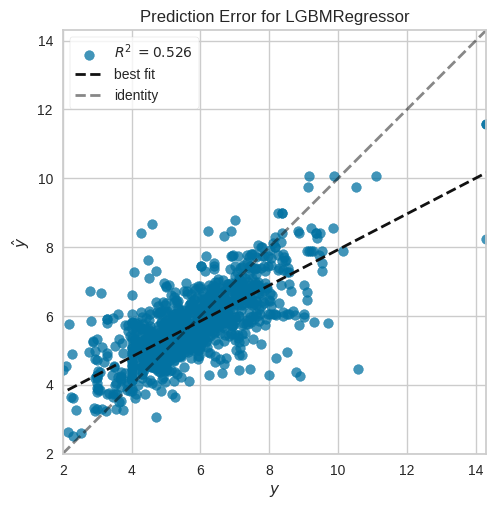

In [14]:
plot_model(tuned_model, plot='error')


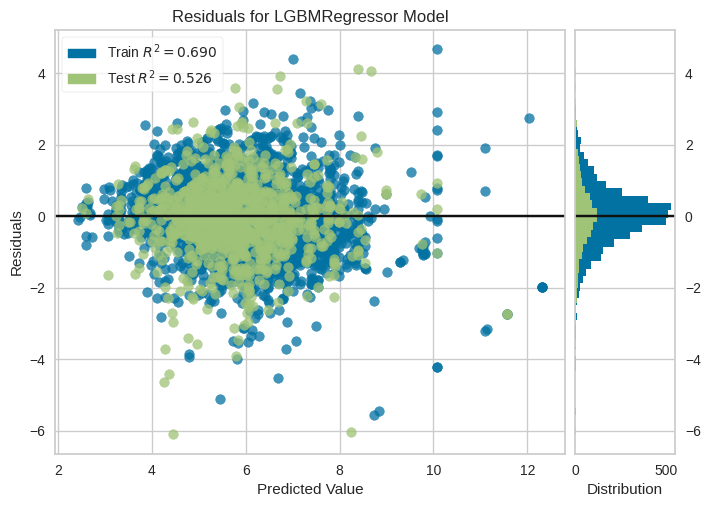

In [15]:
plot_model(tuned_model, plot='residuals')

In [16]:
# Create test dataframe
test_df = pd.DataFrame(X_test)
test_df['pIC50'] = Y_test.reset_index(drop=True)

# Drop any rows where pIC50 is missing in test data (if any)
test_df = test_df.dropna(subset=['pIC50']).reset_index(drop=True)

# Predict using best model
predictions = predict_model(tuned_model, data=test_df)

# 10. Show predictions
print(predictions.head())

# 11. (Optional) Save the best model to a file
# save_model(best_model, 'best_pycaret_model')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7735,1.1441,1.0696,0.5212,0.1604,0.1458


   0  1  2  3  4  5  6  7  8  9  ...  136  137  138  139  140  141  142  143  \
0  0  0  0  0  0  0  0  0  1  1  ...    1    1    0    0    1    1    1    0   
1  1  1  0  1  0  1  1  1  0  0  ...    1    0    0    1    1    1    0    0   
2  1  0  0  1  0  0  0  0  0  0  ...    0    0    0    1    0    0    0    0   
3  0  1  0  1  0  1  1  1  0  0  ...    1    0    0    1    1    1    0    0   
4  0  0  0  1  1  1  1  1  1  1  ...    1    1    0    1    1    1    1    0   

      pIC50  prediction_label  
0  5.273273          5.704860  
1  6.419075          6.511676  
2  3.596948          4.959649  
3  5.659160          6.309012  
4  4.000000          4.305572  

[5 rows x 146 columns]


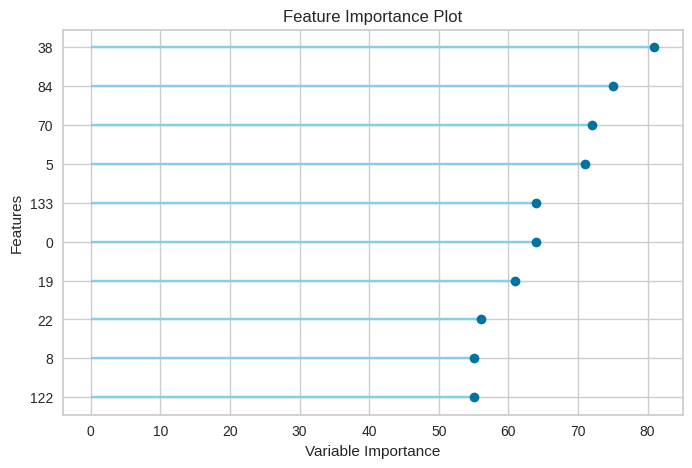

In [17]:
plot_model(tuned_model, plot='feature')

In [18]:
feature_names = train_df.drop('pIC50', axis=1).columns


In [20]:
X_train_only = train_df.drop('pIC50', axis=1)

 97%|=================== | 5162/5312 [00:39<00:01]       

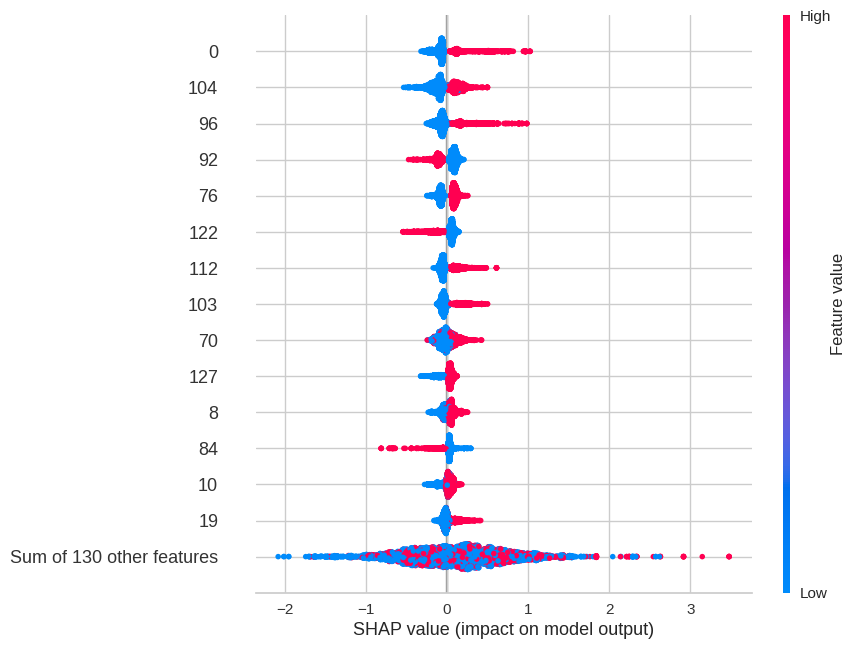

In [22]:
# Step 2: Use tuned_model directly
explainer = shap.Explainer(tuned_model, X_train_only)
shap_values = explainer(X_train_only)

# Step 3: Visualize global SHAP summary
shap.plots.beeswarm(shap_values, max_display=15)